In [41]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gp

from copy import copy
from unidecode import unidecode
from functools import reduce
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from bias_correction import BiasCorrection, XBiasCorrection

relevant_municipalities = ["buenos aires bahia blanca", "buenos aires coronel pringles", "buenos aires hipolito yrigoyen", "buenos aires coronel dorrego", "buenos aires coronel suarez", "buenos aires saavedra", "santa fe san justo"]

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read data

**Polygon shapes**

To forecast wheat yield in Argentina, we use weather data from specific locations. In this notebook we read hindcasts from the C3S that is provided in 1° x 1° grid cells. For each location, we need to find the grid cells that are closest. 

In [42]:
# polygon shapes of the two municipalities that are relevant for the forecast model
gdf_adm2 = gp.read_file("data/shapefile/arg_admbnda_adm2_unhcr2017.shp")[["ADM1_ES", "ADM2_ES", "geometry"]]
# concatenate name of state and municipality
gdf_adm2["name"] = gdf_adm2[["ADM1_ES", "ADM2_ES"]].apply(lambda x: unidecode(x[0].lower()) + " " + unidecode(x[1].lower()), axis=1)
# filter the two relevant names
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(["buenos aires bahia blanca", "buenos aires coronel pringles", "buenos aires hipolito yrigoyen", "buenos aires coronel dorrego", "buenos aires coronel suarez", "buenos aires saavedra", "santa fe san justo"]), ["name", "geometry"]].reset_index(drop=True)
# convert to dictionary for easier access
name_to_shape = gdf_adm2.set_index("name")["geometry"].to_dict()
# preview
name_to_shape

{'buenos aires coronel suarez': <POLYGON Z ((-61.603 -36.993 0, -61.735 -37.093 0, -61.735 -37.095 0, -61.73...>,
 'buenos aires bahia blanca': <POLYGON Z ((-62.219 -38.435 0, -62.198 -38.452 0, -62.084 -38.363 0, -62.04...>,
 'buenos aires coronel dorrego': <POLYGON Z ((-61.175 -38.293 0, -61.174 -38.293 0, -61.173 -38.293 0, -61.17...>,
 'buenos aires coronel pringles': <POLYGON Z ((-61.001 -37.823 0, -60.988 -37.833 0, -60.853 -37.94 0, -60.846...>,
 'buenos aires hipolito yrigoyen': <POLYGON Z ((-61.45 -36.052 0, -61.435 -36.039 0, -61.393 -36.072 0, -61.333...>,
 'santa fe san justo': <POLYGON Z ((-60.667 -29.918 0, -60.611 -29.927 0, -60.599 -29.928 0, -60.58...>,
 'buenos aires saavedra': <POLYGON Z ((-62.044 -37.753 0, -62.067 -37.833 0, -62.092 -37.913 0, -62.09...>}

**ERA data**

The ERA5-Land-Reanalysis [Dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=form) is needed to bias-adjustment.

In [43]:
era = pd.read_csv("data/era_filtered_locations_v2.csv").assign(model="ERA", init_month=12)
# the redundant part of the location "Buenoas Aires" can be removed
era["name"] = era["name"].apply(lambda x: x.replace("buenos aires ", ""))
era = era[["model", "year", "init_month", "month", "rain", "tmean", "name"]]
era.columns = ["model", "year", "init_month", "forecasted_month", "rain", "tmean", "location"]
# preview
era.head(2)

,model,year,init_month,forecasted_month,rain,tmean,location
0,ERA,1993,12,8,0.000122,10.427311,bahia blanca
1,ERA,1993,12,9,0.000719,12.046370,bahia blanca


In [44]:
# read hindcasts
list_hindcasts = []
for model in ["ECCC", "ECCC_operational"]:
    df = xr.open_dataset("data/" + model + "/" + model.lower() + ".grib").to_dataframe()
    df["tprate"] = df["tprate"] * 86400  # seconds per day 
    df = df.groupby(["time", "step", "latitude", "longitude", "valid_time"]).agg({"t2m":"mean", "tprate":"mean"}).dropna().assign(model=model).reset_index()
    df["t2m"] = df["t2m"].apply(lambda x: x - 273.15)
    list_hindcasts.append(df)
hindcasts = pd.concat(list_hindcasts, axis=0, ignore_index=False)


### 2. Basic Preprocessing

In [46]:
# security copy
c3s = hindcasts.copy()

In [47]:
hindcasts = c3s.copy()

In [48]:
hindcasts.loc[hindcasts["model"] == "ECCC_operational", "model"] = "ECCC"

In [49]:
# convert to datetime
hindcasts["time"] = pd.to_datetime(hindcasts["time"])
hindcasts["valid_time"] = pd.to_datetime(hindcasts["valid_time"])

In [50]:
# for JMA hindcasts that are initialized at the end of the month we bring them to start date as the first day of the next month
hindcasts.loc[(hindcasts["time"].dt.day.between(26, 31)) & (hindcasts["model"] == "JMA"), "time"] = hindcasts.loc[(hindcasts["time"].dt.day.between(26, 31)) & (hindcasts["model"] == "JMA"), "time"].apply(lambda x: x.replace(day=1) + relativedelta(months=1))
# filter init days that are not at the beginning of the month
hindcasts = hindcasts.loc[(hindcasts["time"].dt.day == 1)].reset_index(drop=True)

In [51]:
# derive year and month
hindcasts["init_month"] = hindcasts["time"].dt.month
hindcasts["forecasted_month"] = hindcasts["valid_time"].dt.month - 1
hindcasts["year"] = hindcasts["time"].dt.year
hindcasts["forecasted_year"] = hindcasts["valid_time"].dt.year

# filter
hindcasts = hindcasts.loc[(hindcasts["year"] == hindcasts["forecasted_year"])
                          & (hindcasts["init_month"].between(8,11)) & (hindcasts["forecasted_month"].between(8,11))].reset_index(drop=True)

# rename and reorder
hindcasts = hindcasts.rename(columns={"latitude":"lat", "longitude":"lon", "t2m":"tmean", "tprate":"rain"})
hindcasts = hindcasts[["model", "year", "init_month", "forecasted_month", "rain", "tmean", "lat", "lon"]]

# convert to geodataframe to facilitate spatial filtering in the next section
hindcasts = gp.GeoDataFrame(hindcasts, geometry=gp.points_from_xy(hindcasts["lon"], hindcasts["lat"]), crs="EPSG:4326")

### 3. Find closest location to municipalities

<Axes: >

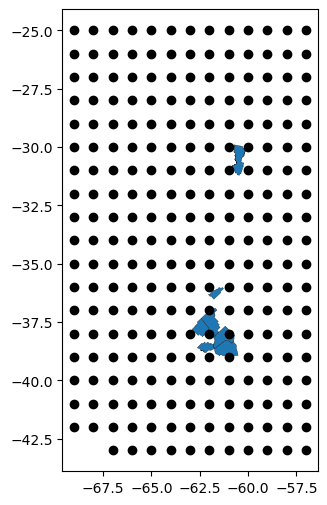

In [30]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gp.GeoDataFrame(hindcasts[["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

In [31]:
modelling_groups = hindcasts["model"].unique()
li = []
print(relevant_municipalities)
for model in modelling_groups:
    # get current model and the lat-lon coordinates of its forecasts
    current_model = hindcasts.loc[hindcasts["model"] == model, ["model", "lat", "lon", "geometry"]].drop_duplicates()
    # get the nearest lat-lon pair to both locations (municipalities)
    location_1 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[0]])[1][0]]).transpose().assign(location="coronel suarez").reset_index(drop=True)
    location_2 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[1]])[1][0]]).transpose().assign(location="bahia blanca").reset_index(drop=True)
    location_3 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[2]])[1][0]]).transpose().assign(location="coronel dorrego").reset_index(drop=True)
    location_4 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[3]])[1][0]]).transpose().assign(location="coronel pringles").reset_index(drop=True)
    location_5 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[4]])[1][0]]).transpose().assign(location="hipolito yrigoyen").reset_index(drop=True)
    location_6 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[5]])[1][0]]).transpose().assign(location="santa fe san justo").reset_index(drop=True)
    location_7 = pd.DataFrame(current_model.iloc[current_model.sindex.nearest(name_to_shape[relevant_municipalities[6]])[1][0]]).transpose().assign(location="saavedra").reset_index(drop=True)
    # save in dataframe
    locations = pd.concat([location_1, location_2, location_3, location_4, location_5, location_6, location_7], ignore_index=True)
    # the lat-lon pairs that are selected are merged with the name of their location; all other lat-lon pairs are dropped
    current_model = current_model.merge(locations, on=["model", "lat", "lon", "geometry"], how="left").dropna()
    # append the locations for this model
    li.append(current_model)
    
model_locations = pd.concat(li, ignore_index=True, axis=0)
hindcasts = hindcasts.merge(model_locations, on=["model", "lat", "lon", "geometry"]).dropna()

['buenos aires bahia blanca', 'buenos aires coronel pringles', 'buenos aires hipolito yrigoyen', 'buenos aires coronel dorrego', 'buenos aires coronel suarez', 'buenos aires saavedra', 'santa fe san justo']


<Axes: >

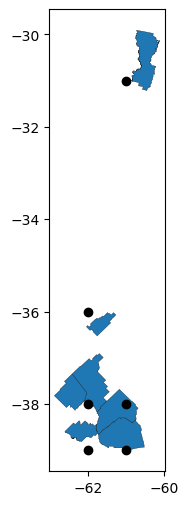

In [32]:
base = gdf_adm2.plot(figsize=(6,6), edgecolor="black", linewidth=.2)
gp.GeoDataFrame(hindcasts[["geometry", "lat", "lon"]].drop_duplicates(), geometry="geometry", crs="EPSG:4326").plot(ax=base,  color="black")

In [40]:
eccc = hindcasts.loc[hindcasts["init_month"] == 10].reset_index(drop=True)
eccc.to_csv("data/ECCC_operational/ECCC_operational.csv", index=False)

### 4. Bias Adjustment

In [34]:
def adjust_bias(observed, predicted, correction_method="basic_quantile"):
    """Apply bias-adjustment to daily temperature values of hindcasts.
    
    parameters:
     - observed: observed climate data
     - predicted: hindcast data
     - correction_method: bias-correction method to be applied. Can be 'normal_mapping', 'basic_quantile', 'gamma_mapping', 'modified_quantile'
    
    returns: 
     - results: bias-adjusted hindcasts as dataframe  
    """
    # GroupBy objects allow faster access to relevant subsets of climate data.
    grouped_climate_observations = observed.groupby(["location", "year", "forecasted_month"])
    grouped_climate_hindcasts = predicted.groupby(["model", "init_month", "location", "year", "forecasted_month"])
    grouped_climate_hindcasts_reference = copy(grouped_climate_hindcasts)
    li = []
    
    for group_idx, group_content in grouped_climate_hindcasts:
        # Save group characteristics in intuitive variables.
        current_model = group_content["model"].unique()[0]
        current_init_month = group_content["init_month"].unique()[0]
        current_zone = group_content["location"].unique()[0]
        current_season = group_content["year"].unique()[0]
        current_month = group_content["forecasted_month"].unique()[0]
        
        # Create calibration set of observations and hindcasts.
        hindcasts_used_as_reference = []
        observations_used_as_reference = []
        for season in list(range(1993,2017)): 
            if season != current_season:
                observation_to_be_added = (current_zone, season, current_month) 
                observations_used_as_reference.append(grouped_climate_observations.get_group(observation_to_be_added))   
            hindcast_to_be_added = (current_model, current_init_month, current_zone, season, current_month)
            hindcasts_used_as_reference.append(grouped_climate_hindcasts_reference.get_group(hindcast_to_be_added))
        hindcasts_used_as_reference = pd.concat(hindcasts_used_as_reference, axis=0, ignore_index=False)
        observations_used_as_reference = pd.concat(observations_used_as_reference, axis=0, ignore_index=False) 
        
        # Perform bias-adjustment for temperature variables.
        bc_tmean = BiasCorrection(observations_used_as_reference["tmean"], hindcasts_used_as_reference["tmean"], group_content["tmean"])
        bc_rain = BiasCorrection(observations_used_as_reference["rain"], hindcasts_used_as_reference["rain"], group_content["rain"])
        group_content["tmean"] = bc_tmean.correct(method=correction_method)
        group_content["rain"] = bc_rain.correct(method=correction_method)
        
        li.append(group_content)
    result = pd.concat(li, axis=0, ignore_index=True)       
    
    return result

In [35]:
adjusted_hindcasts = adjust_bias(era, hindcasts)

KeyboardInterrupt: 

### 5. Feature structure

In [29]:
# Bring NMME hindcasts into right structure where features are columns and rows are model-year-init_month
hindcasts_pivot = adjusted_hindcasts.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
hindcasts_pivot.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in hindcasts_pivot.columns]
hindcasts_pivot.columns = [c.strip("_") for c in hindcasts_pivot.columns]

# Bring ERA into right structure where features are columns and rows are model-year
era_pivot = era.pivot(index=["model", "year", "init_month"], columns=["location", "forecasted_month"], values=["tmean", "rain"]).reset_index()
era_pivot.columns = ["{}_{}_{}".format(c[0], c[1], c[2]) for c in era_pivot.columns]
era_pivot.columns = [c.strip("_") for c in era_pivot.columns]
era_pivot = era_pivot.sort_values(by=["model", "year", "init_month"])

# features for month < init_months are NaNs and will be replaced with era-reanalysis data
all_models = hindcasts_pivot.set_index("year").combine_first(era_pivot.set_index("year")).reset_index()
# concat ERA with init_month = 12  
all_models = pd.concat([all_models, era_pivot], ignore_index=True)
all_models = all_models.drop_duplicates().reset_index(drop=True)
all_models = all_models.loc[all_models["init_month"] >= 9].sort_values(by=["model", "year", "init_month"]).reset_index(drop=True)



In [33]:
# bring columns into right order
all_models = all_models.set_index(['model', 'year', 'init_month']).reset_index()

## EXPORT

In [34]:
all_models.to_csv("data/features/bias_adjusted_c3s_features_v2.csv", index=False)